First, load the package and instantiate the dependencies.

In [1]:
using Pkg
pkg"activate .; instantiate; precompile" # may take a long time the first time this is run

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...
Precompiling PerlaTonettiWaugh


┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.1/PerlaTonettiWaugh/Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1184


And load the deps

In [2]:
using CSV, Plots, JSON, BenchmarkTools, Parameters, PerlaTonettiWaugh, DataFrames, Suppressor
gr(fmt = :png)

Plots.GRBackend()

## Stationary Solutions

First, define common objects for the full model

In [3]:
parameters = parameter_defaults(); # model parameters
settings = settings_defaults(); # numerical solution settings

To solve for time 0 and ``T`` stationary solutions, simply:

In [4]:
@unpack stationary_T, stationary_0, change_welfare, change_trade = compare_steady_states(parameters, settings);

We can inspect each:

In [5]:
@show (stationary_0.g, stationary_0.z_hat, stationary_0.Ω, stationary_0.L_tilde)

(stationary_0.g, stationary_0.z_hat, stationary_0.Ω, stationary_0.L_tilde) = (0.006957088129667934, 1.9806967954735208, 0.9633490175041199, 0.2319424283503491)


(0.006957088129667934, 1.9806967954735208, 0.9633490175041199, 0.2319424283503491)

And

In [6]:
@show (stationary_T.g, stationary_T.z_hat, stationary_T.Ω, stationary_T.L_tilde)

(stationary_T.g, stationary_T.z_hat, stationary_T.Ω, stationary_T.L_tilde) = (0.008830960000907917, 1.8426170489641287, 0.9113956321186734, 0.23654087175887434)


(0.008830960000907917, 1.8426170489641287, 0.9113956321186734, 0.23654087175887434)

And display the other objects:

In [7]:
@show change_welfare;

change_welfare = 7.855134617413229


In [8]:
@show change_trade;

change_trade = 0.03807150526164149


## Autarky

Let's also define and inspect the autarky steady state

In [9]:
# Solve for the autarky case
defaults = parameter_defaults()
params_autarky = merge(defaults, (d_T = 1 + (defaults.d_0-1)*2.5,))

autarky_results = compare_steady_states(params_autarky, settings, verbose = true);
# quantities we need for later analysis
stationary_autarky = autarky_results.stationary_T;
lambda_ss_autarky = autarky_results.change_welfare;

SS to SS welfare gain: -15.989617027704362
Change in Trade: -0.10050907092749606
Growth Rates across SS: 0.2514793420331128 (time T) vs 0.6957088129667933 (time 0)


## Transition Dynamics

The code is

In [10]:
cachename = model_cachename(parameters, settings) # uniquely identify the run by parameters + settings
cachepath = joinpath(pwd(), "data", cachename * ".csv")
use_cache = true # change this to false if you don't want to use the cache for a run
write_cache = true # change this to false if you don't want to generate *any* cache files for a run

# reading
if isfile(cachepath) && use_cache
    println("using cache.")
    solved = CSV.read(cachepath);
else
    println("solving without cache.")
    @time solution = @suppress solve_transition(parameters, settings);
    solved = solution.results 
end

# writing
if write_cache
    mkpath(joinpath(pwd(), "data")) # if this doesn't eist for whatever reason
    CSV.write(cachepath, solved) # write DataFrame
    write(joinpath(pwd(), "data", cachename * ".json"), JSON.json((parameters = parameters, settings = merge(settings, (interp = typeof(settings.interp), stationary_x0 = typeof(settings.stationary_x0), fixedpoint_x0 = typeof(settings.fixedpoint_x0) ))))) # write parameters
else
    # nothing
end

filter!(row -> row.t >= 0, solved) # don't plot pre-shock values

solving without cache.
523.893880 seconds (2.12 G allocations: 808.946 GiB, 24.66% gc time)


,t,g,z_hat,Ω,E,v_1,L_tilde,entry_residual,λ_ii,S,z_bar,c,π_min,log_M,U,π_rat,L_tilde_a,L_tilde_x,L_tilde_E,w,r
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0078895,1.86704,0.963349,0.0158641,4.95047,0.219849,0.0,0.862434,0.104693,1.36779,1.06709,0.18185,0.0,20.1111,2.20936,0.100856,0.0279437,0.0910494,0.936654,0.0475052
2,0.25,0.00789582,1.86687,0.962876,0.0159109,4.95047,0.220052,0.0,0.862403,0.104724,1.36751,1.06658,0.181886,0.00197317,20.203,2.20947,0.100836,0.0279426,0.0912733,0.936457,0.0475224
3,0.5,0.00790213,1.8667,0.962405,0.0159575,4.95047,0.220254,0.0,0.862373,0.104756,1.36722,1.06608,0.181921,0.00394791,20.2951,2.20958,0.100817,0.0279414,0.0914956,0.936261,0.0475395
4,0.75,0.00790843,1.86653,0.961936,0.0160037,4.95047,0.220455,0.0,0.862343,0.104787,1.36694,1.06559,0.181957,0.00592423,20.3872,2.20969,0.100799,0.0279404,0.0917162,0.936066,0.0475566
5,1.0,0.00791471,1.86637,0.96147,0.0160497,4.95047,0.220655,0.0,0.862313,0.104819,1.36665,1.0651,0.181992,0.00790212,20.4795,2.20981,0.10078,0.0279393,0.0919352,0.935872,0.0475737
6,1.25,0.00792099,1.8662,0.961006,0.0160955,4.95047,0.220853,0.0,0.862283,0.10485,1.36637,1.06461,0.182027,0.00988159,20.5719,2.20992,0.100762,0.0279383,0.0921526,0.935679,0.0475908
7,1.5,0.00792726,1.86603,0.960544,0.0161409,4.95047,0.221049,0.0,0.862253,0.104882,1.36609,1.06412,0.182063,0.0118626,20.6644,2.21003,0.100743,0.0279373,0.0923684,0.935487,0.0476079
8,1.75,0.00793352,1.86587,0.960084,0.0161861,4.95047,0.221244,0.0,0.862223,0.104913,1.36581,1.06363,0.182098,0.0138452,20.757,2.21014,0.100725,0.0279364,0.0925826,0.935296,0.0476249
9,2.0,0.00793978,1.8657,0.959627,0.016231,4.95047,0.221438,0.0,0.862193,0.104944,1.36553,1.06315,0.182133,0.0158294,20.8498,2.21025,0.100707,0.0279355,0.0927952,0.935106,0.0476419


## Welfare

Here's welfare inclusive of the transition path:

In [11]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_0.U_bar, parameter_defaults())-1);
@show lambda_tpath;

lambda_tpath = 8.01309977743896


## Plots

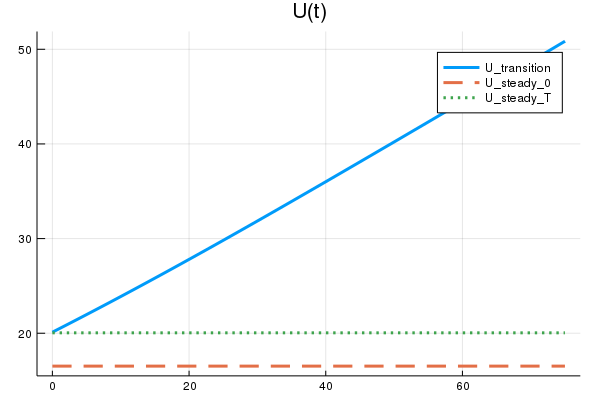

In [12]:
U_steady_0(t) = stationary_0.U_bar
U_steady_T(t) = stationary_T.U_bar

plot(solved.t,
   [solved.U, U_steady_0, U_steady_T],
   label = ["U_transition", "U_steady_0", "U_steady_T"] ,
   title = "U(t)", linestyle = :auto, lw = 3)

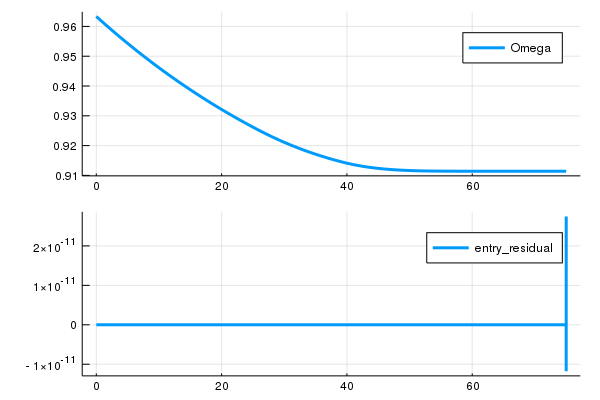

In [13]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

Here are the static equations

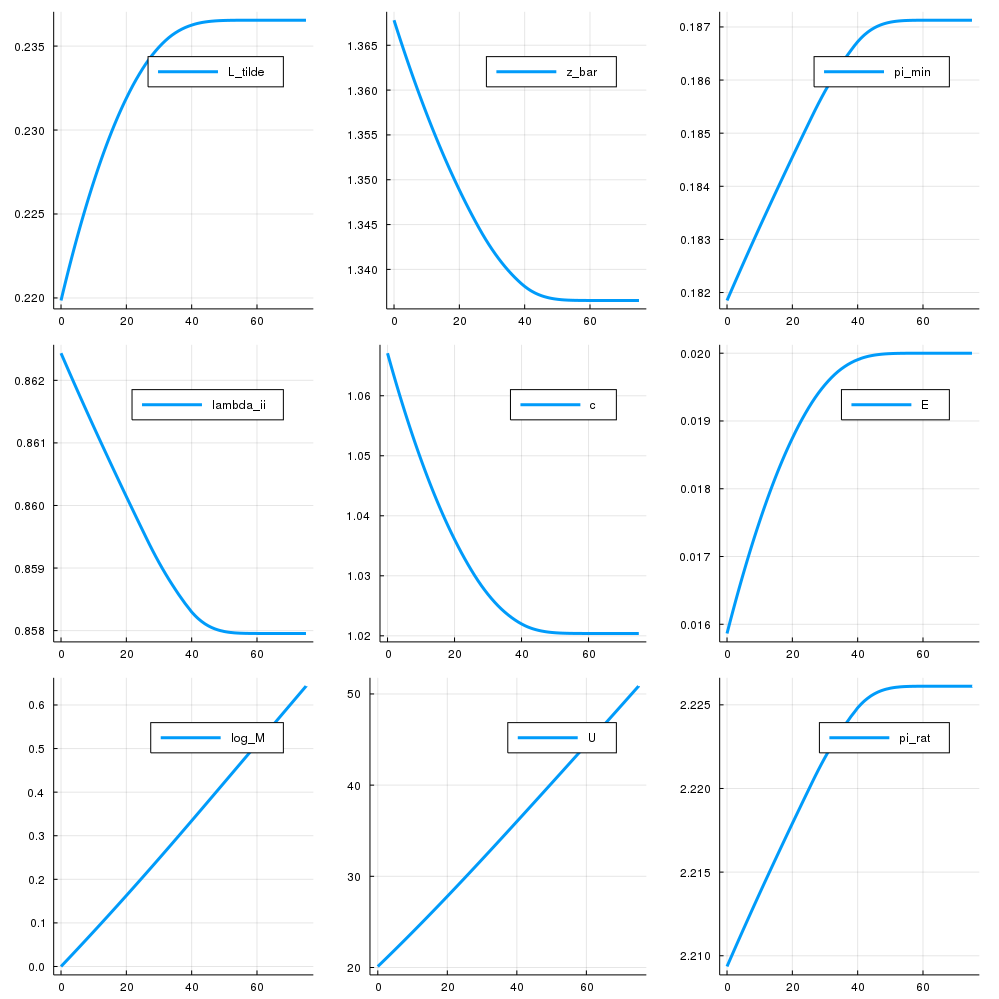

In [14]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(solved.t, solved.π_rat, label = "pi_rat", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, layout=(3,3), size = (1000, 1000))

And a more granular look at welfare

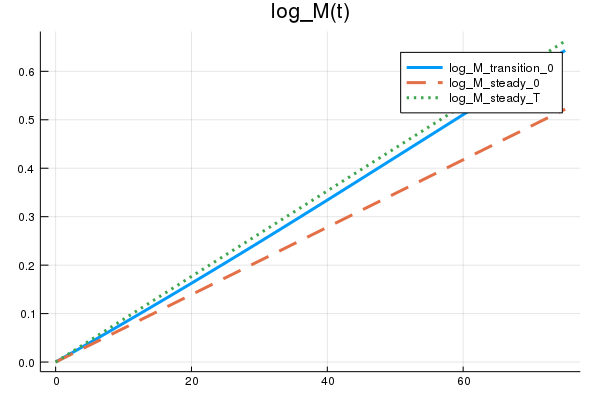

In [15]:
log_M_steady_0(t) = stationary_0.g * t
log_M_steady_T(t) = stationary_T.g * t

plot(solved.t,
    [solved.log_M, log_M_steady_0, log_M_steady_T],
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

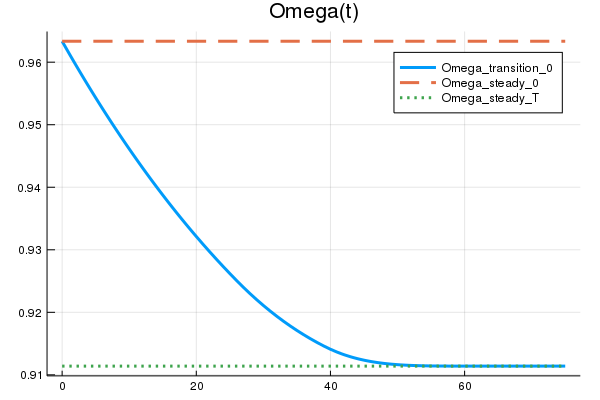

In [16]:
Ω_steady_0(t) = stationary_0.Ω
Ω_steady_T(t) = stationary_T.Ω

plot(solved.t,
    [solved.Ω, Ω_steady_0, Ω_steady_T],
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

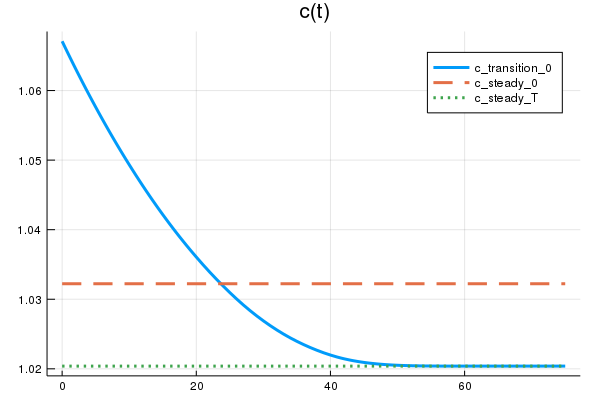

In [17]:
c_steady_0(t) = stationary_0.c
c_steady_T(t) = stationary_T.c

plot(solved.t,
    [solved.c, c_steady_0, c_steady_T],
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

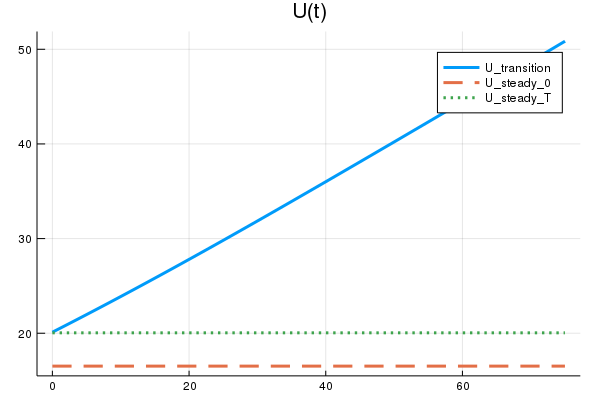

In [18]:
U_steady_0(t) = stationary_0.U_bar
U_steady_T(t) = stationary_T.U_bar

plot(solved.t,
    [solved.U, U_steady_0, U_steady_T],
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

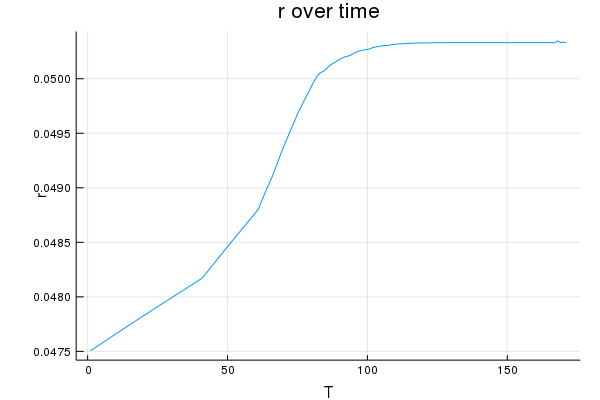

In [19]:
plot(solved.r, legend = false, title = "r over time", xlabel = "T", ylabel = "r")

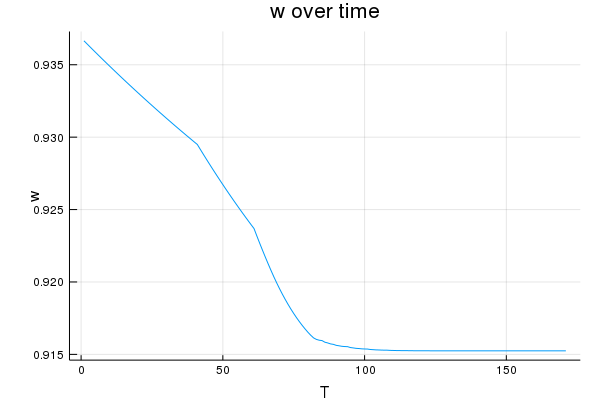

In [20]:
plot(solved.w, legend = false, title = "w over time", xlabel = "T", ylabel = "w")

Here's the labor share breakdown

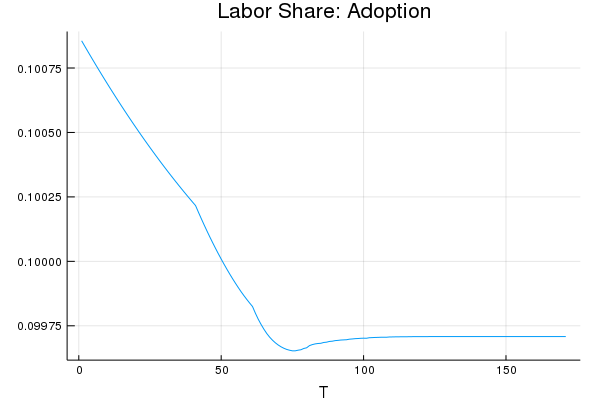

In [21]:
plot(solved.L_tilde_a, legend = false, xlabel = "T", title = "Labor Share: Adoption")

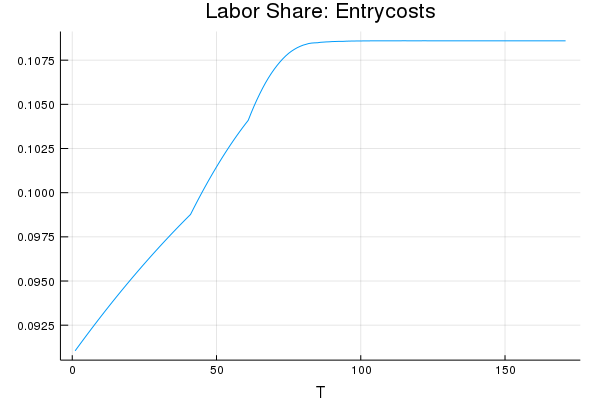

In [22]:
plot(solved.L_tilde_E, legend = false, xlabel = "T", title = "Labor Share: Entrycosts")

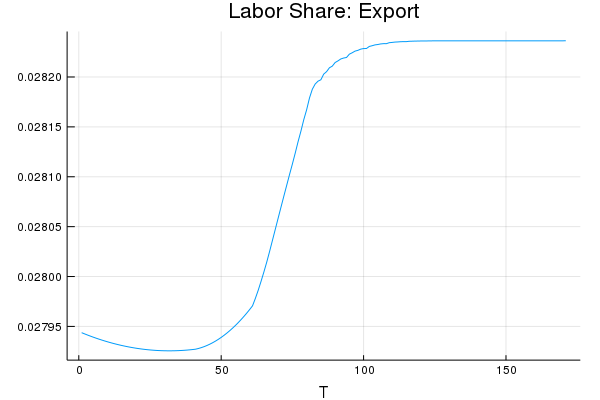

In [23]:
plot(solved.L_tilde_x, legend = false, xlabel = "T", title = "Labor Share: Export")

And the consumption equivalent

In [24]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_0.U_bar, parameter_defaults())

1.0801309977743896

## Writing Data

Save welfare and autarky dataframes.

In [25]:
df_welfare = DataFrame(steady_state = change_welfare, transition_path = lambda_tpath, growth_rate = stationary_T.g, theta = parameter_defaults().θ);
write_cache && CSV.write("data/welfare_results-" * cachename * ".csv", df_welfare)

"data/welfare_results-18262156669967332791.csv"

In [26]:
df_autarky = DataFrame(steady_state = lambda_ss_autarky, growth_rate = stationary_autarky.g, theta = parameter_defaults().θ);
write_cache && CSV.write("data/autarky_results-" * cachename * ".csv", df_autarky)

"data/autarky_results-18262156669967332791.csv"